# Lagrangian particle tracking

Material particles following ocean currents can be analyzed in terms of trajectories. These can simply be computed by integrating velocities through time within a [Lagrangian framework](https://en.wikipedia.org/wiki/Lagrangian_and_Eulerian_specification_of_the_flow_field). In `Julia` this is easily done using the [IndividualDisplacements.jl](https://JuliaClimate.github.io/IndividualDisplacements.jl/dev/) and [OrdinaryDiffEq.jl](https://docs.juliadiffeq.org/latest) packages.

## Import software, grid, and velocity fields

1. pre-requisites
2. read variables

_Note: rerunning this notebook requires [nctiles_climatology/](ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_climatology/) e.g. via wget_

```
run(`wget --recursive ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_climatology`)
run(`mv mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_climatology ../inputs/`)
```

In [1]:
using IndividualDisplacements, MeshArrays, OrdinaryDiffEq
using Plots, Statistics, MITgcmTools, DataFrames

if !isdir("../inputs/GRID_LLC90")
    run(`git clone https://github.com/gaelforget/GRID_LLC90 ../inputs/GRID_LLC90`)
end

mypath="../inputs/GRID_LLC90/"
mygrid=GridSpec("LatLonCap",mypath); GridVariables=GridLoad(mygrid)
GridVariables=merge(GridVariables,IndividualDisplacements.NeighborTileIndices_cs(GridVariables));

In [2]:
pth="../inputs/nctiles_climatology/"
msg="Please download $pth from e.g. `ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/`"
!isdir("$pth"*"UVELMASS") ? error(msg) : nothing
!isdir("$pth"*"VVELMASS") ? error(msg) : nothing

fileName="../inputs/nctiles_climatology/UVELMASS/UVELMASS"
u=Main.read_nctiles(fileName,"UVELMASS",mygrid)
fileName="../inputs/nctiles_climatology/VVELMASS/VVELMASS"
v=Main.read_nctiles(fileName,"VVELMASS",mygrid);

## Pre-Process Gridded Variables

1. Select depth & time
2. normalize to grid units
3. apply exchange function to `u,v,lon,lat`
4. store everything in a dictionary

In [3]:
#u=dropdims(mean(u,dims=3),dims=3); v=dropdims(mean(v,dims=3),dims=3)
u=u[:,20,1]; v=v[:,20,1]; msk=(GridVariables["hFacC"][:,20] .> 0.) #select depth and time

u[findall(isnan.(u))]=0.0; v[findall(isnan.(v))]=0.0 #mask with 0s rather than NaNs
u=u./GridVariables["DXC"]; v=v./GridVariables["DYC"]; #normalization to grid units

In [4]:
(u,v)=exchange(u,v,1) #add 1 point at each edge for u and v
XC=exchange(GridVariables["XC"]) #add 1 lon point at each edge
YC=exchange(GridVariables["YC"]) #add 1 lat point at each edge

t0=0.0; t1=86400*366*10.0; dt=10*86400.0;
uvt = Dict("u0" => u, "u1" => u, "v0" => v, "v1" => v,
    "t0" => t0, "t1" => t1, "dt" => dt, "msk" => msk)
uvetc=merge(uvt,GridVariables); #store everything in a dictionary

## Set-up Trajectory Computation

1. set `comp_vel`, an alias, to standard interpolation function
2. define `uInitS` as an array of initial conditions

In [5]:
comp_vel=IndividualDisplacements.VelComp! #3.1 set `comp_vel`, an alias, to standard interpolation function

uInitS = Array{Float64,2}(undef, 3, prod(XC.grid.ioSize)) #3.2 define `uInitS` as an array of initial conditions

kk = 0
for fIndex = 1:5
        nx, ny = XC.fSize[fIndex]
        ii1 = 0.5:1.0:nx
        ii2 = 0.5:1.0:ny
        n1 = length(ii1)
        n2 = length(ii2)
        for i1 in eachindex(ii1)
          for i2 in eachindex(ii2)
            if msk[fIndex][Int(round(i1+0.5)),Int(round(i2+0.5))]
                        global kk += 1
                        let kk = kk
                                uInitS[1, kk] = ii1[i1]
                                uInitS[2, kk] = ii2[i2]
                                uInitS[3, kk] = fIndex
                        end
            end
          end
        end
end

uInitS=uInitS[:,1:kk]
du=fill(0.0,size(uInitS));

## Compute Trajectories

_Note: settings of `ODEProblem` and `solve` can likely be improved to go even faster_

In [6]:
tspan = (0.0,uvt["t1"]-uvt["t0"])
prob = ODEProblem(comp_vel,uInitS,tspan,uvetc)
sol = solve(prob,Euler(),dt=uvt["dt"])
size(sol)

(3, 54408, 367)

## Post-Process Trajectories

1. Copy `sol` to a `DataFrame`
2. Map position to lon,lat coordinates

In [7]:
ID=collect(1:size(sol,2))*ones(1,size(sol,3))
x=sol[1,:,:]
y=sol[2,:,:]
fIndex=sol[3,:,:]
df = DataFrame(ID=Int.(ID[:]), x=x[:], y=y[:], fIndex=fIndex[:])
size(df)

(19967736, 4)

In [8]:
lon=Array{Float64,1}(undef,size(df,1)); lat=similar(lon)

for ii=1:length(lon)
    #get location in grid index space
    x=df[ii,:x]; y=df[ii,:y]; fIndex=Int(df[ii,:fIndex])
    dx,dy=[x - floor(x),y - floor(y)]
    i_c,j_c = Int32.(floor.([x y])) .+ 2
    #interpolate lon and lat to position
    tmp=view(YC[fIndex],i_c:i_c+1,j_c:j_c+1)
    lat[ii]=(1.0-dx)*(1.0-dy)*tmp[1,1]+dx*(1.0-dy)*tmp[2,1]+(1.0-dx)*dy*tmp[1,2]+dx*dy*tmp[2,2]
    
    tmp=view(XC[fIndex],i_c:i_c+1,j_c:j_c+1)
    if (maximum(tmp)>minimum(tmp)+180)&&(lat[ii]<88)
        tmp1=deepcopy(tmp)
        tmp1[findall(tmp.<maximum(tmp)-180)] .+= 360.
        tmp=tmp1
    end
    #kk=findall(tmp.<maximum(tmp)-180); tmp[kk].=tmp[kk].+360.0
    lon[ii]=(1.0-dx)*(1.0-dy)*tmp[1,1]+dx*(1.0-dy)*tmp[2,1]+(1.0-dx)*dy*tmp[1,2]+dx*dy*tmp[2,2]
end

df.lon=lon; df.lat=lat; #show(df[end-3:end,:])

## Plot Trajectories


For example, you can:

- use either `Makie.jl` via `PlotMakie`
- or use `PyPlot.jl` via `PlotMapProj`


In [9]:
p=dirname(pathof(IndividualDisplacements)); nn=10000
#include(joinpath(p,"plot_pyplot.jl")); PyPlot.figure(); PlotMapProj(df,nn)
include(joinpath(p,"plot_makie.jl")); AbstractPlotting.inline!(true); #for Juno, set to false

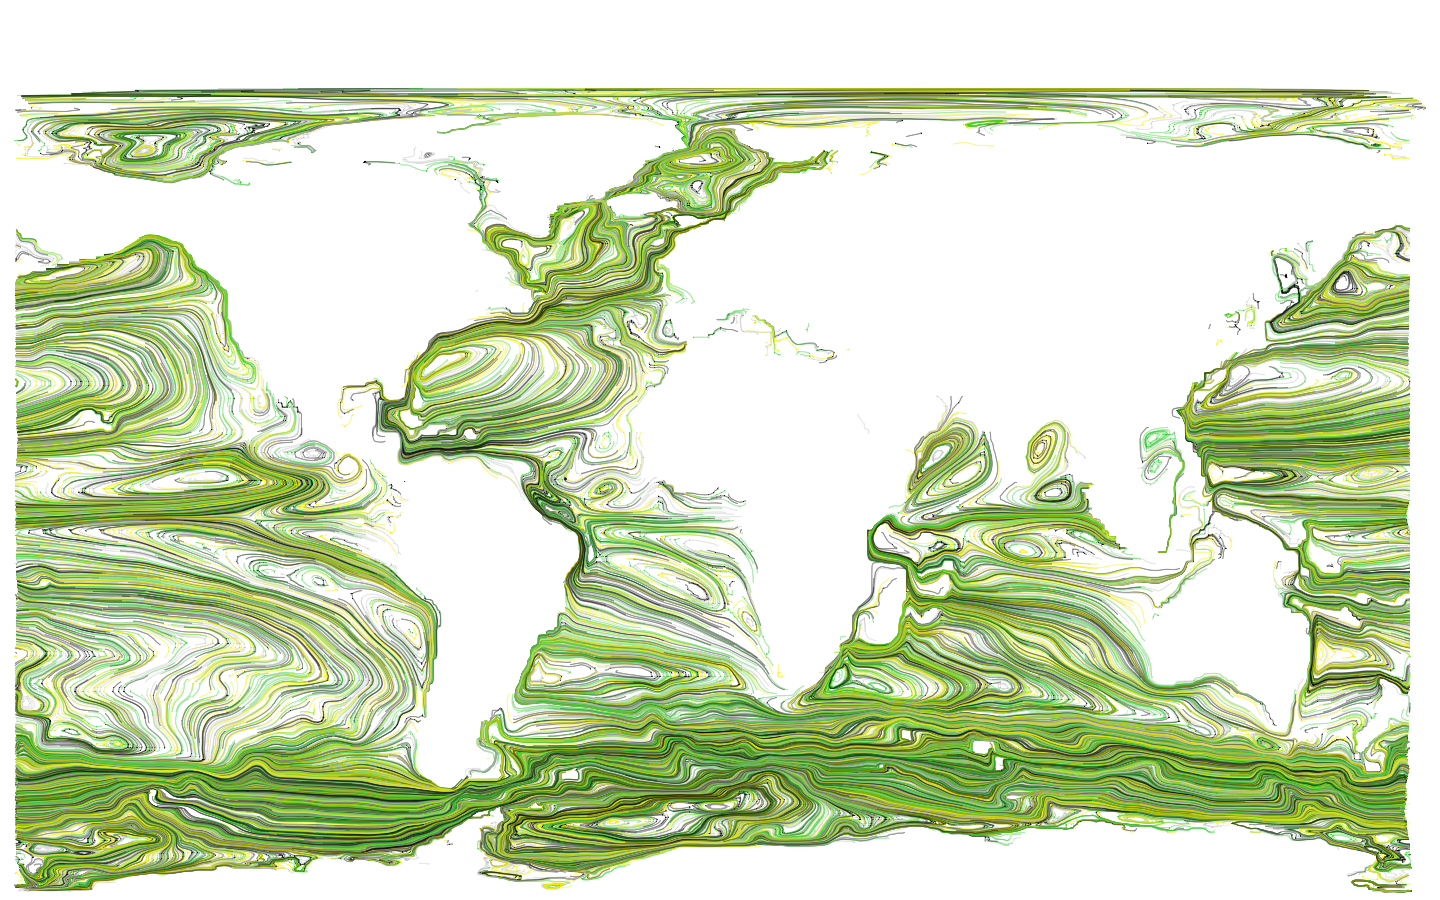

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /Users/gforget/.julia/packages/AbstractPlotting/rWoon/src/display.jl:114


In [10]:
scene=PlotMakie(df,nn,180.0) #Makie.save("LatLonCap300mDepth.png", scene)